# Sparkify Project
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [4]:
# # This cell is used on AWS EMR

# import os
# import re
# import sys
# print("start SPARK application")
# os.environ["SPARK_HOME"] = "/usr/lib/spark/"
# os.environ["PYSPARK_PYTHON"] = "/mnt/anaconda3/bin/python3.7"
# spark_home = os.environ.get('SPARK_HOME', None)
# sys.path.insert(0, spark_home + "/python")
# sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-src.zip'))



start SPARK application


In [5]:
# # This cell is used on AWS EMR
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.master("yarn") \
#     .config("spark.dynamicAllocation.enabled", "true") \
#     .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
#     .config("spark.shuffle.spill.compress", "true") \
#     .config("spark.shuffle.service.enabled", "true") \
#     .config("spark.io.compression.codec", "snappy") \
#     .config("spark.driver.memory", "24g") \
#     .config("spark.driver.cores", "4") \
#     .config("spark.executor.cores", "4") \
#     .config("spark.executor.memory", "24g") \
#     .config("spark.kryoserializer.buffer.max", "2000m") \
#     .config("spark.network.timeout", "360000") \
#     .config("spark.dynamicAllocation.minExecutors", "25")\
#     .enableHiveSupport() \
#     .getOrCreate()
# spark.conf.set("spark.sql.broadcastTimeout", 72000)

In [36]:
# import libraries
import os
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType, Row, DateType
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import  MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


%matplotlib inline

In [7]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

In [8]:
# create a Spark session for LOCAL 
# spark = SparkSession \
#     .builder \
#     .appName("Sparkify") \
#     .getOrCreate()

# Read in full sparkify dataset
event_data = "medium-sparkify-event-data.json"

In [9]:
# df = spark.read.json('s3://<bucket-name>/ElifSurmeli/' + event_data)

In [11]:
# pd.DataFrame(df.take(5), columns=df.columns).head()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [12]:
def cleanse_data(df):
    """
    Removes special characters from StringType columns 
    (special chars. except , and - which might be useful for splitting columns)
    Casts miliseconds ts column and creates two new columns with timestamptype and datetype,
    which will be used for further processing
    Extracts month from ts
    Casts user id to LongType
    Splits location field and takes only state name as location
    :param df: Spark DataFrame
    :return df preprocessed Spark DataFrame
    """
    # cleanse stringtype fields from special characters
    for field in df.schema.fields:
        if field.dataType==StringType():
            df = df.withColumn(field.name, regexp_replace(field.name, '[^a-zA-Z0-9\,\-]', ''))
    # create new ts related columns
    df = df.withColumn('interaction_time', from_unixtime(col('ts').cast(LongType())/1000).cast(TimestampType()))
    df = df.withColumn('month', month(col('interaction_time')))
    df = df.withColumn('date', from_unixtime(col('ts')/1000).cast(DateType()))
    
    df = df.withColumn('userId', col('userId').cast(LongType()))
    # remove user id null
    df = df.filter(col('userId').isNotNull())
    # filter out log out records
    df = df = df.filter(col('auth')!='LoggedOut')
    # replace location with extracting state from it
    df = df.withColumn('location', split(col('location'),',').getItem(1))
    
    return df
    

In [13]:
def label_data(df):
    """
    Calculates features from existing fields
    Adds label column
    :param df: spark DataFrame
    """
   
    label_df = df.withColumn('label',
                             when((col('page').\
                                   isin(['Cancellation Confirmation','Cancel'])) | \
                                  (col('auth')=='Cancelled'),1 ).\
                             otherwise(0)).\
    groupby('userId').agg(sum('label').alias('label')).\
    withColumn('label', when(col('label')>=1 ,1).otherwise(0))

    df = df.join(label_df, on='userId')

    return df

In [14]:
def registered_days(df):
    """
    Calculates number of days between registration to last interaction
    :param df: spark DataFrame
    :return df with calculated column
    """
    last_interaction_df =  df.groupBy('userId').agg(max('ts').alias('last_interaction'))

    df = last_interaction_df.join(df, on='userId').withColumn('registered_days', ((col('last_interaction')-col('registration'))/86400000).cast(IntegerType()))
    return df

In [15]:
def latest_level(df):
    """
    Finds the latest level of each user
    :param df: spark DataFrame
    :return df with latest level assigned to each user
    """
    level_df = df.orderBy('ts', ascending=False).groupBy('userId').agg(first('level').alias('valid_level'))
    
    df = df.drop('level')
    df = df.join(level_df, on='userId')
    return df

In [16]:
def avg_length(df):
    """
    Calculates average item length for each user
    :param df: spark DataFrame
    :return df with average length column
    """
    avg_length_df = df.groupBy('userId').avg('length').withColumnRenamed('avg(length)', 'length')
    
    df = df.drop('length')
    df = df.join(avg_length_df, on='userId')
    return df


In [17]:
def sessionid_aggregates(df):
    """
    Calculates daily and monthly average of distinct sessionId for each user
    :param df:spark DataFrame
    :return daily and monthly aggregates DataFrame
    """
    daily_session_df = df.groupby('userId','date').agg(countDistinct('sessionId')).\
    groupBy('userId').avg('count(DISTINCT sessionId)').\
    withColumnRenamed('avg(count(DISTINCT sessionId))', 'avg_daily_sessions')
    
    monthly_session_df = df.groupby('userId','month').agg(countDistinct('sessionId')).\
    groupBy('userId').avg('count(DISTINCT sessionId)').\
    withColumnRenamed('avg(count(DISTINCT sessionId))', 'avg_monthly_sessions')
    
    return daily_session_df.join(monthly_session_df, on='userId')
    

In [18]:
def session_duration_aggregates(df):
    """
    Calculates daily and monthly average of distinct sessionId for each user
    :param df:spark DataFrame
    :return daily and monthly aggregates DataFrame
    """
    daily_session_duration_df = df.groupby('userId','date','sessionId').\
    agg(max('ts').alias('session_end'), min('ts').alias('session_start')).\
    withColumn('session_duration_sec', (col('session_end')-col('session_start'))*0.001).\
    groupby('userId','date').\
    avg('session_duration_sec').\
    groupby('userId').\
    agg(mean('avg(session_duration_sec)').alias('avg_daily_session_duration')).\
    orderBy('userId', ascending=False)
    
    monthly_session_duration_df = df.groupby('userId','month','sessionId').\
    agg(max('ts').alias('session_end'), min('ts').alias('session_start')).\
    withColumn('session_duration_sec', (col('session_end')-col('session_start'))*0.001).\
    groupby('userId','month').\
    avg('session_duration_sec').\
    groupby('userId').\
    agg(mean('avg(session_duration_sec)').alias('avg_monthly_session_duration')).\
    orderBy('userId', ascending=False)
    
    return daily_session_duration_df.join(monthly_session_duration_df, on='userId')


    

In [19]:
def item_aggregates(df):
    """
    Calculates monthly, daily averages for each user,for each item 
    :param df: spark DataFrame
    :return daily and monthly aggregates DataFrame
    """
    daily_item_df = df.groupby('userId','date').agg(max('itemInSession')).\
    groupBy('userId').avg('max(itemInSession)').\
    withColumnRenamed('avg(max(itemInSession))', 'avg_daily_items')
    
    monthly_item_df = df.groupby('userId','month').agg(max('itemInSession')).\
    groupBy('userId').avg('max(itemInSession)').\
    withColumnRenamed('avg(max(itemInSession))', 'avg_monthly_items')
    
    return daily_item_df.join(monthly_item_df, on='userId')
    
    

In [20]:
def page_event_aggregates(df):
    """
    Calculates monthly, daily averages for each user,for each page event except the ones that include "cancel" 
    :param df: spark DataFrame
    :return daily and monthly aggregates DataFrame
    """
    
    listOfDistinctPages = [row.page for row in df.select('page').distinct().collect()]
    listOfDistinctPages.remove('Cancel')
    listOfDistinctPages.remove('CancellationConfirmation')
    
    daily_page_event_df = df.groupby('userId','date').pivot('page').count()
    exp_dict={}
    for page in listOfDistinctPages:
        exp_dict.update({page:'mean'})

    daily_page_event_df = daily_page_event_df.join(daily_page_event_df.groupBy('userId').agg(exp_dict).fillna(0), on='userId')

    for page in listOfDistinctPages:
        daily_page_event_df = daily_page_event_df.drop(page)  
        daily_page_event_df = daily_page_event_df.withColumnRenamed('avg({})'.format(page), 'avg_daily_{}'.format(page))

    daily_page_event_df = daily_page_event_df.drop('Cancel','CancellationConfirmation','date').drop_duplicates()
    
    
    monthly_page_event_df = df.groupby('userId','month').pivot('page').count()

    monthly_page_event_df = monthly_page_event_df.join(monthly_page_event_df.groupBy('userId').agg(exp_dict).fillna(0), on='userId')

    for page in listOfDistinctPages:
        monthly_page_event_df = monthly_page_event_df.drop(page)    
        monthly_page_event_df = monthly_page_event_df.withColumnRenamed('avg({})'.format(page), 'avg_monthly_{}'.format(page))

    monthly_page_event_df = monthly_page_event_df.drop('Cancel','CancellationConfirmation','month').drop_duplicates()

    return daily_page_event_df.join(monthly_page_event_df, on='userId')


In [21]:
def join_all_features(df, df_sess_id, df_sess_duration, df_item, df_page):
    """
    Joins all aggregate dataframes and main dataframe for couple of original columns
    :param df: main dataframe
    :param df_sess_id: daily,monthly session id features dataframe
    :param df_sess_duration: daily,monthly session duration features dataframe
    :param df_item: daily,monthly item features dataframe
    :param df_page: daily,monthly page events features dataframe
    :return features spark dataframe with all generated features
    """

    all_aggs_df =\
    df_sess_id\
    .join(df_sess_duration, on='userId')\
    .join(df_item, on='userId')\
    .join(df_page, on='userId')

    # auth is dropped as it has single value 'Logged In' after initial cleanup
    # month, date, ts, interaction time, registration are removed as these are not relevant when one row
    # for user is left and these have been used for aggregation, the information is hidden in agg features
    # page, length, sessionId, itemInsession have been removed as these have been used for aggregations
    # artist, song, method, status, userAgent have been removed to avoid complexity
    # firstName, lastName has been removed as they're redundant.user id sufficient to identify customer
    df = df.drop('auth', 'level','length','userAgent','month','date','interaction_time','registration', 'ts','song','page','itemInSession','sessionId','artist','firstName','lastName','method','status')
    joined_df = all_aggs_df.join(df, on='userId')
    
    joined_df = joined_df.drop_duplicates()
    features = joined_df.drop('userId')
    
    return features

In [22]:
def build_pipeline(num_cols):
    """
    Adds string indexer for categorical columns
    Vector assembler for numerical columns
    Creates a pipeline with indexer and assembler
    :param num_cols:  list of numerical column names
    :return data processing pipeline
    """
    
    indexer_gender = StringIndexer(inputCol='gender', outputCol='gender_index')
    indexer_location = StringIndexer(inputCol='location', outputCol='location_index')
    indexer_valid_level = StringIndexer(inputCol='valid_level', outputCol='valid_level_index')

    assembler = VectorAssembler(inputCols=num_cols, outputCol='features')

    process_pipeline = Pipeline(stages=[indexer_gender, indexer_location, indexer_valid_level, assembler])

    return process_pipeline


In [40]:
def post_process_data(features_df):
    """
    Transforms features with feature pipeline
    :param features_df: Spark DataFrame of features
    :return Spark Dataframe with label and assembled features
    """
    num_cols = []
    
    for field in features_df.schema.fields :
        if field.dataType!=StringType():
            num_cols.append(field.name)

    num_cols.remove('label')

    process_pipeline = build_pipeline(num_cols)
    model_df = process_pipeline.fit(features_df).transform(features_df)
#     return model_df.select("label", "features")
    return model_df

In [41]:
def fit_predict(train, test, model):
    """
    Fits and runs predictions with given training and test data
    Displays results for given model
    :param train : Spark dataframe with training data
    :param test : a Spark data frame with testing data
    :param model : model name as string, either 'logistic_regression', 'random_forest' 
                    or 'gradient_boosting'
    :return 
    """

    if model == 'logistic_regression':
        ml = LogisticRegression()
    elif model == 'random_forest':
        ml = RandomForestClassifier()
    elif model == 'gradient_boosting':
        ml = GBTClassifier()
    else:
        return "Please choose an appropriate model"
    
    # Fit and calculate predictions
    clf = ml.fit(train)
    results = clf.transform(test)
    # Precision – Of all the users that the algorithm predicts will churn, how many of them do actually churn?
    # So f1 is more important than accuracy as it takes into account.it explains how robust and precise the model is.
    # it is important for us to classify no churn customers correctly otherwise we might take wrong actions,
    # or we might take actions that we shouldn't take which might confuse the customer
    # auc tells how much model is capable of distinguishing between classes and probability that 
    # the classifier will rank a randomly chosen positive example higher than a randomly chosen negative example
    evaluate_model(results)
    return clf, results


In [42]:
def evaluate_model(results):
    """
    Runs output evaluator on the prediction results
    :param results: Spark DataFrame, model prediction outputs
    :return None
    """

    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    print('The F1 score on the test set is {:.2%}'.format(f1_score)) 
    
    auc_evaluator = BinaryClassificationEvaluator()
    metric_value = auc_evaluator.evaluate(results, {auc_evaluator.metricName: "areaUnderROC"})
    print('The areaUnderROC on the test set is {:.2%}'.format(metric_value))
    

In [43]:
def tune_rf(train, test, numTrees=[20,75], maxDepth=[10,20]):
    """
    Tunes numTrees and maxDepth parameters for random forest classifier
    Runs gridsearch,evaluates the results and prints best parameters
    :param train : training data
    :param test : test data
    :param numTrees : List of integers,Number of trees in the random forest
    :param maxDepth : List of integers, Maximum depth of the tree
    :return None
    """
    clf = RandomForestClassifier()
    
    paramGrid = ParamGridBuilder() \
        .addGrid(clf.numTrees, numTrees) \
        .addGrid(clf.maxDepth, maxDepth) \
        .build()   
    
    crossval = CrossValidator(estimator = Pipeline(stages=[clf]),
                         estimatorParamMaps = paramGrid,
                         evaluator = MulticlassClassificationEvaluator(metricName='f1'),
                         numFolds = 3)

    cvModel = crossval.fit(train)
    predictions = cvModel.transform(test)
    
    evaluate_model(predictions)
    
    bestPipeline = cvModel.bestModel

    # prints feature importances
    for i in range(len(bestPipeline.stages[0].featureImportances)):
        print("{} : {} \n".format(features_df.columns[i], bestPipeline.stages[0].featureImportances[i]))

    print('Best parameters : max depth:{}, num Trees:{}'.\
          format(bestPipeline.stages[0].getOrDefault('maxDepth'), bestPipeline.stages[0].getNumTrees))


In [27]:
df = cleanse_data(df)

In [28]:
df = label_data(df)
df = registered_days(df)
df = latest_level(df)
df = avg_length(df)
df_sess_id = sessionid_aggregates(df)
df_sess_duration = session_duration_aggregates(df)
df_item = item_aggregates(df)
df_page = page_event_aggregates(df)

features_df = join_all_features(df, df_sess_id, df_sess_duration, df_item, df_page)

In [29]:
pd.DataFrame(features_df.take(5), columns=features_df.columns).head()

,avg_daily_sessions,avg_monthly_sessions,avg_daily_session_duration,avg_monthly_session_duration,avg_daily_items,avg_monthly_items,avg_daily_RollAdvert,avg_daily_Settings,avg_daily_Downgrade,avg_daily_NextSong,avg_daily_Error,avg_daily_About,avg_daily_Upgrade,avg_daily_Home,avg_daily_Logout,avg_daily_AddtoPlaylist,avg_daily_ThumbsDown,avg_daily_ThumbsUp,avg_daily_SaveSettings,avg_daily_AddFriend,avg_daily_SubmitUpgrade,avg_daily_Help,avg_daily_SubmitDowngrade,avg_monthly_RollAdvert,avg_monthly_Settings,avg_monthly_Downgrade,avg_monthly_NextSong,avg_monthly_Error,avg_monthly_About,avg_monthly_Upgrade,avg_monthly_Home,avg_monthly_Logout,avg_monthly_AddtoPlaylist,avg_monthly_ThumbsDown,avg_monthly_ThumbsUp,avg_monthly_SaveSettings,avg_monthly_AddFriend,avg_monthly_SubmitUpgrade,avg_monthly_Help,avg_monthly_SubmitDowngrade,last_interaction,gender,location,label,registered_days,valid_level
0,1.000000,2.0,12856.333333,19435.500000,67.666667,124.0,0.000000,1.000000,0.000000,43.000000,0.00,1.00,2.000000,3.333333,3.000000,2.000000,0.000000,3.500000,0.0,2.666667,1.0,0.000000,0.0,0.0,1.0,0.0,129.0,0.0,1.0,2.0,10.0,3.0,4.0,0.0,7.0,0.0,8.0,1.0,0.0,0.0,1540856767000,M,CA,0,46,paid
1,1.285714,19.5,10934.466667,12644.206522,74.742857,211.5,3.842105,1.083333,1.125000,54.485714,1.25,1.25,1.333333,3.214286,1.722222,2.285714,1.416667,3.461538,1.0,2.857143,1.0,1.555556,1.0,36.5,6.5,4.5,953.5,5.0,2.5,2.0,45.0,15.5,24.0,8.5,45.0,1.0,20.0,1.0,7.0,1.0,1543536707000,M,CA,0,75,paid
2,1.083333,6.0,4033.750000,5306.375000,28.750000,83.5,4.625000,0.000000,0.000000,24.900000,0.00,0.00,2.000000,1.900000,1.125000,3.000000,1.000000,1.285714,0.0,1.500000,0.0,1.500000,0.0,18.5,0.0,0.0,124.5,0.0,0.0,2.0,9.5,4.5,3.0,1.0,4.5,0.0,3.0,0.0,1.5,0.0,1542726950000,M,FL,0,181,free
3,1.320000,13.5,14999.980000,16690.200549,106.240000,461.0,3.111111,2.000000,1.909091,74.250000,1.00,1.00,1.400000,3.304348,1.500000,3.538462,1.875000,5.933333,1.0,2.400000,1.0,1.600000,1.0,14.0,7.0,10.5,891.0,1.0,3.0,3.5,38.0,12.0,23.0,7.5,44.5,1.5,18.0,1.0,4.0,1.0,1543525111000,M,NH,0,71,paid
4,1.000000,1.5,7729.333333,6241.000000,40.000000,51.5,3.500000,0.000000,0.000000,33.000000,0.00,0.00,1.000000,1.000000,1.000000,2.000000,1.000000,2.500000,0.0,0.000000,0.0,0.000000,0.0,7.0,0.0,0.0,49.5,0.0,0.0,1.0,1.5,1.0,2.0,2.0,2.5,0.0,0.0,0.0,0.0,0.0,1542594291000,M,WA,0,71,free


In [31]:
features_df.select([count(when(isnull(c), c)).alias(c) for c in features_df.columns]).show()

+------------------+--------------------+--------------------------+----------------------------+---------------+-----------------+--------------------+------------------+-------------------+------------------+---------------+---------------+-----------------+--------------+----------------+-----------------------+--------------------+------------------+----------------------+-------------------+-----------------------+--------------+-------------------------+----------------------+--------------------+---------------------+--------------------+-----------------+-----------------+-------------------+----------------+------------------+-------------------------+----------------------+--------------------+------------------------+---------------------+-------------------------+----------------+---------------------------+----------------+------+--------+-----+---------------+-----------+
|avg_daily_sessions|avg_monthly_sessions|avg_daily_session_duration|avg_monthly_session_duration|avg_

**No missing values left, no need for imputation**

In [32]:
features_df.printSchema()

root
 |-- avg_daily_sessions: double (nullable = true)
 |-- avg_monthly_sessions: double (nullable = true)
 |-- avg_daily_session_duration: double (nullable = true)
 |-- avg_monthly_session_duration: double (nullable = true)
 |-- avg_daily_items: double (nullable = true)
 |-- avg_monthly_items: double (nullable = true)
 |-- avg_daily_RollAdvert: double (nullable = false)
 |-- avg_daily_Settings: double (nullable = false)
 |-- avg_daily_Downgrade: double (nullable = false)
 |-- avg_daily_NextSong: double (nullable = false)
 |-- avg_daily_Error: double (nullable = false)
 |-- avg_daily_About: double (nullable = false)
 |-- avg_daily_Upgrade: double (nullable = false)
 |-- avg_daily_Home: double (nullable = false)
 |-- avg_daily_Logout: double (nullable = false)
 |-- avg_daily_AddtoPlaylist: double (nullable = false)
 |-- avg_daily_ThumbsDown: double (nullable = false)
 |-- avg_daily_ThumbsUp: double (nullable = false)
 |-- avg_daily_SaveSettings: double (nullable = false)
 |-- avg_daily_

In [48]:
# saves features df
# features_df.write.csv('s3://BUCKETNAME/KEYNAME/sparkify_features.csv')

**Stats for Generated Features**

In [49]:
pd_features = features_df.toPandas()

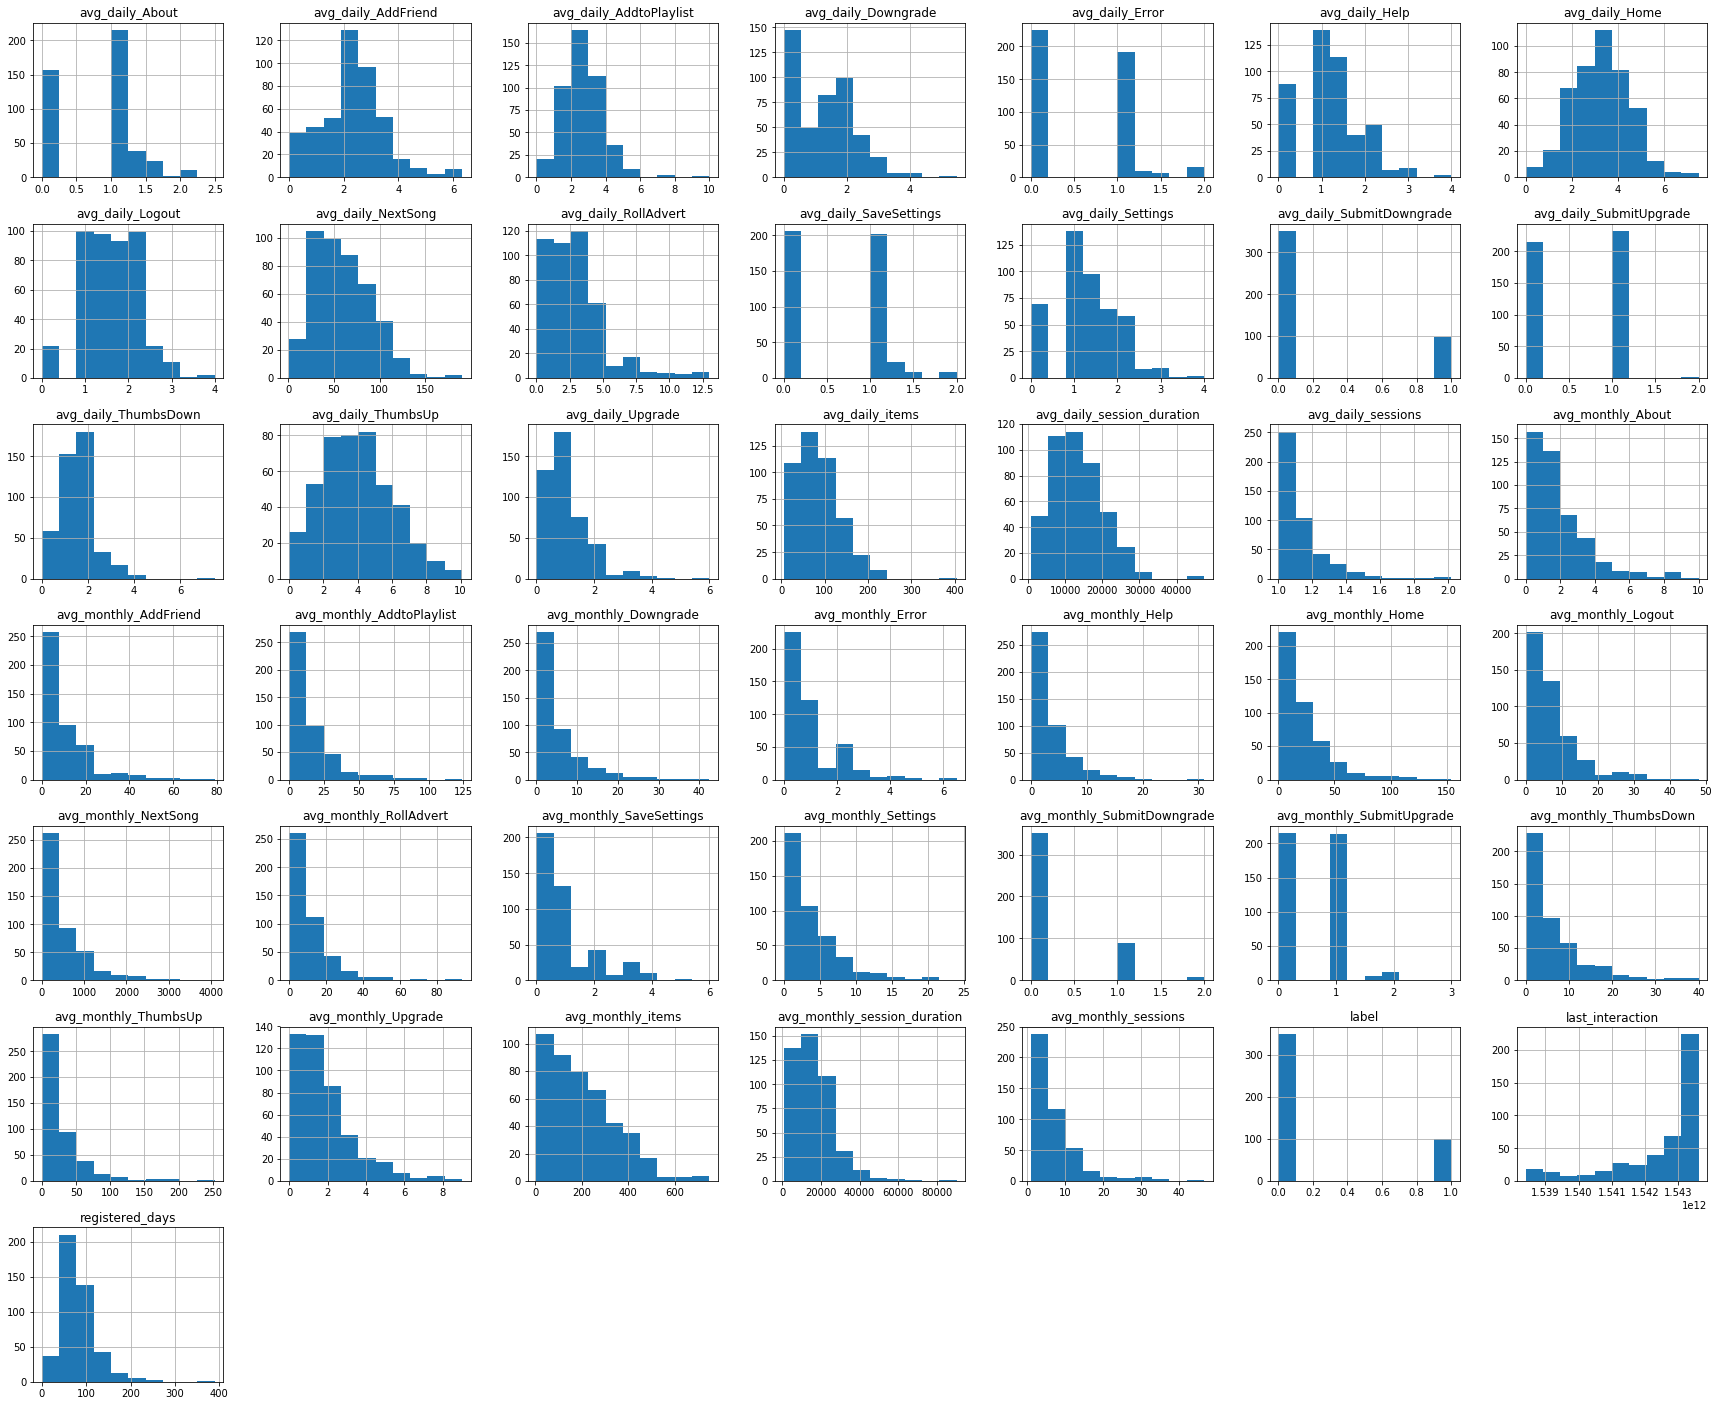

In [54]:
fig = plt.figure(figsize=(30,25))
ax = fig.gca()
h = pd_features.hist(ax=ax)

**We can see that most of the features are skewed,normalization might be required, unless a model such as Random Forest which is insensitive to imbalance is used.**

In [44]:
model_data = post_process_data(features_df)

In [45]:
# Split the data into train and test subsets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

In [46]:
# Fit various models and visualize their accuracies
for model in ['logistic_regression', 'random_forest', 'gradient_boosting']:
    fit_predict(train, test, model)

The F1 score on the test set is 79.83%
The areaUnderROC on the test set is 67.17%
The F1 score on the test set is 87.81%
The areaUnderROC on the test set is 95.08%
The F1 score on the test set is 85.68%
The areaUnderROC on the test set is 88.83%


In [47]:
tune_rf(train, test)

The F1 score on the test set is 91.03%
The areaUnderROC on the test set is 93.25%
avg_daily_sessions : 0.04236219536508317 

avg_monthly_sessions : 0.03951447819898451 

avg_daily_session_duration : 0.02073779077811611 

avg_monthly_session_duration : 0.016396278628309786 

avg_daily_items : 0.020040353630460424 

avg_monthly_items : 0.022926933384472603 

avg_daily_RollAdvert : 0.019136923054740844 

avg_daily_Settings : 0.011941227131888258 

avg_daily_Downgrade : 0.031236702500548493 

avg_daily_NextSong : 0.020031676506489873 

avg_daily_Error : 0.01060494226669709 

avg_daily_About : 0.007224374876162774 

avg_daily_Upgrade : 0.012733572835209593 

avg_daily_Home : 0.01920648890489164 

avg_daily_Logout : 0.018050186448982566 

avg_daily_AddtoPlaylist : 0.016338040792397833 

avg_daily_ThumbsDown : 0.025872235569742604 

avg_daily_ThumbsUp : 0.01928372234833034 

avg_daily_SaveSettings : 0.0030900180252398236 

avg_daily_AddFriend : 0.02046474611531954 

avg_daily_SubmitUpgrade : 